# REDES NEURONALES PROFUNDAS

Importamos las librerías:

In [ ]:
# Tensorflow y tf.keras
import tensorflow as tf
from tensorflow import keras

# Otras librerías:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import time

Accedemos al sistema de ficheros de Google:

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## INICIALIZACIÓN:

Cargamos los datos:

In [ ]:
ATT_FILE = "./HotelReservationsPreparedCleanAttributes.csv"
LABEL_FILE = "./HotelReservationsOutput.csv"

# Lo establecemos en 0.8 para obtener una partición 80% / 10% / 10% del dataset.
TRAIN_RATE = 0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0] # Número de instancias total.
n_train = int(n_instances*TRAIN_RATE) # Número de instancias para entrenamiento (80%)
n_dev = int((n_instances-n_train)/2) # Número de instancias para dev test / final test (10%)

# Cogemos las n_train primeras instancias para el entrenamiento.
x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

# Cogemos las siguientes n_dev siguientes instancias para dev test.
x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:", x_train.shape)
print ("t_train:", t_train.shape)

print ("x_dev:", x_dev.shape)
print ("t_dev:", t_dev.shape)


x_train: (29016, 16)
t_train: (29016, 1)
x_dev: (3627, 16)
t_dev: (3627, 1)


Inicializamos las variables:

In [ ]:
INPUTS = x_train.shape[1] # Número de variables.
OUTPUTS = t_train.shape[1] # Número de etiquetas de salida.
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1)) # Número de instancias empleadas para entrenamiento.
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1)) # Número de instancias empleadas para dev.

Mostramos algunas instancias para comprobar que son correctas:

In [ ]:
print('x_train:')
print()
print(x_train[:5])
print()
print('t_train:')
print()
print(t_train[:10])
print()
print('x_dev:')
print()
print(x_dev[:5])
print()
print('t_dev:')
print()
print(t_dev[:5])

x_train:

[[ 0.5        -1.         -0.71428571 -0.64705882 -1.         -1.
   1.         -0.87810384  0.09090909  0.6         0.         -1.
  -1.         -1.         -0.3247037  -1.        ]
 [ 0.         -1.         -0.42857143 -0.29411765 -1.         -1.
   1.         -0.6523702  -0.63636364  0.46666667 -1.         -1.
  -1.         -1.         -0.79259259 -1.        ]
 [ 0.         -1.         -1.         -0.52941176 -1.         -1.
   0.          0.16930023  0.63636364 -0.73333333 -1.         -1.
  -1.         -1.         -0.67037037 -1.        ]
 [ 0.         -1.         -0.42857143 -1.         -1.         -1.
   0.         -0.67945824  0.63636364  0.93333333  0.         -1.
  -1.         -1.         -0.72022222 -0.6       ]
 [ 0.         -1.         -1.         -0.76470588  1.         -1.
   0.         -0.93227991  0.27272727 -0.93333333  0.         -1.
  -1.         -1.         -0.54074074 -1.        ]]

t_train:

[[0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]]

x_dev:

[[ 

## HIPERPARÁMETROS:

In [ ]:
n_epochs = 1000
learning_rate = 0.0001
batch_size = 2048
n_neurons_per_hidden_layer = [1000, 750, 500, 250, 75, 25]

## MODELO

Emplearemos como función de activación para las capas ocultas la función ReLu ya que nuestro objetivo es crear una red neuronal profunda y, como la función ReLU no se satura con valores altos de entrada (net), evitaremos el *Vanishing Gradients Problem*.

Inicialización:

In [ ]:
# my_initializer = keras.initializers.Zeros()

my_initializer = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1, seed=None)

# my_initializer = keras.initializers.RandomUniform(minval=-0.3, maxval=0.3, seed=None)
# my_initializer = keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=None)
# my_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# my_initializer = keras.initializers.he_normal(seed=None)
# my_initializer = keras.initializers.he_uniform(seed=None)

Regularización:

In [ ]:
dpr = 0.2
# my_regulizer = keras.regularizers.l1(0.001)
# my_regulizer = keras.regularizers.l1(0.0001)
# my_regulizer = keras.regularizers.l2(0.001)
# my_regulizer = keras.regularizers.l2(0.0001)
# my_regulizer = keras.regularizers.l2(0.00005)
# my_regulizer = keras.regularizers.l2(0.00001)
# my_regulizer = keras.regularizers.l1_l2(0.001)

Definición del modelo:

In [ ]:
# Creamos un modelo secuencial vacío.
model = keras.Sequential(name="DNM-HotelReservations")

# Creamos una capa de entrada con el número de inputs especificado.
model.add(keras.layers.InputLayer(input_shape=(INPUTS,)))

# Agregamos 4 capas ocultas con el tamaño especificado previamente.
# Las capas tendrán la función de activación ReLU.
for neurons in n_neurons_per_hidden_layer:
  # model.add(keras.layers.Dense(neurons, activation="elu"))
  model.add(keras.layers.Dense(neurons, activation="elu", kernel_initializer = my_initializer))
  # model.add(keras.layers.Dense(neurons, activation="relu", kernel_initializer = my_initializer, kernel_regularizer = my_regulizer))
  model.add(keras.layers.Dropout(rate=dpr))

# Agregamos una capa de salida con el número de outputs especificado.
# Empleará la función de activación Sigmoid (1 única neurona de salida)
model.add(keras.layers.Dense(OUTPUTS, activation="sigmoid"))
# model.add(keras.layers.Dense(OUTPUTS, activation="sigmoid", kernel_regularizer = my_regulizer))

model.summary()

Model: "DNM-HotelReservations"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              17000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 750)               750750    
                                                                 
 dropout_1 (Dropout)         (None, 750)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               375500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 250)     

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Compilación del modelo empleando distintos optimizadores:

In [ ]:
# Compilamos el modelo.
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
#               metrics=["binary_accuracy"])

# Establecemos como función de pérdida la entropía cruzada binaria.
# Establecemos como métrica de evaluación la precisión binaria.

# OPTIMIZADORES

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
#               metrics=["binary_accuracy"])

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9,  nesterov=True),
#               metrics=["binary_accuracy"])

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9),
#               metrics=["binary_accuracy"])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999),
              metrics=["binary_accuracy"])


## ENTRENAMIENTO

In [ ]:
start_time = time.perf_counter()
history = model.fit(x_train, t_train,
                    batch_size = batch_size,
                    epochs=n_epochs,
                    verbose = 0,
                    validation_data = (x_dev, t_dev))
finish_time = time.perf_counter()

## RESULTADOS DE ENTRENAMIENTO

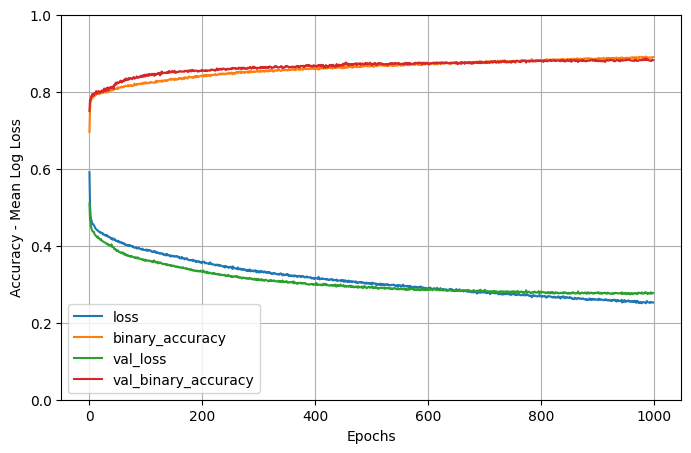

In [ ]:
# Se crea un DF a partir del historial de entrenamiento,
# que contiene las métricas registradas durante el entrenamiento.
results = pd.DataFrame(history.history)
# Gráfica con las métricas obtenidas en el entrenamiento
# en función de las épocas.
results.plot(figsize = (8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0,1]
plt.show()

In [ ]:
# Para obtener los parámetros se accede a la última fila de la matriz,
# correspondiente a los parámetros de la última época, y al último valor de dicha
# fila para obtener el valor de la precisión binaria.
train_error = round((1 - results.binary_accuracy.values[-1:][0])*100, 1)
test_error = round((1 - results.val_binary_accuracy.values[-1:][0])*100, 1)
bayes_error = 10
bias = round((train_error - bayes_error), 1)
variance = round((test_error - train_error), 1)

print ("Error (training): ", train_error, "%")
print ("Error (development test): ", test_error, "%")
print("Bias: ", bias, "%")
print("Variance: ", variance, "%")
print ("Time: ", round((finish_time - start_time)),"seconds")

Error (training):  11.0 %
Error (development test):  11.8 %
Bias:  1.0 %
Variance:  0.8 %
Time:  157 seconds


In [ ]:
history.params

{'verbose': 0, 'epochs': 1000, 'steps': 15}

In [ ]:
results[-1:]

,loss,binary_accuracy,val_loss,val_binary_accuracy
999,0.252409,0.890095,0.277276,0.882272


## DEVELOPMENT TEST SET

Vamos a ver cómo prdice el modelo con el conjunto de Development Test.

In [ ]:
# Obtener predicciones de la red neuronal
dev_predictions = model.predict(x_dev)
dev_predictions[:20]

114/114 [==============================] - 0s 2ms/step


array([[9.2996740e-01],
       [5.0826675e-01],
       [7.2249073e-01],
       [8.5036594e-01],
       [6.3351256e-01],
       [9.9999619e-01],
       [9.3749084e-02],
       [2.6615050e-01],
       [9.9999905e-01],
       [9.9998713e-01],
       [5.2338768e-02],
       [2.2526590e-06],
       [1.6780736e-01],
       [8.7667167e-01],
       [1.6114137e-01],
       [9.5125659e-05],
       [5.2703780e-01],
       [2.4680373e-01],
       [9.9926645e-01],
       [1.0000000e+00]], dtype=float32)

In [ ]:
# Valores objetivo:
t_dev[:20]

array([[1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
 # Redondear las predicciones a 0 o 1
dev_rounded_predictions = np.round(dev_predictions)
# Comparar las predicciones redondeadas con las etiquetas verdaderas
dev_correct_predictions = np.equal(dev_rounded_predictions, t_dev)
# Imprimir las primeras 30 comparaciones de predicciones correctas o incorrectas
print(dev_correct_predictions[:30])

[[ True]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]]


In [ ]:
# Contar el número de predicciones correctas e incorrectas
from collections import Counter
correct_counts = Counter(dev_correct_predictions.flatten())
print("Número de predicciones correctas:", correct_counts[True])
print("Número de predicciones incorrectas:", correct_counts[False])

Número de predicciones correctas: 3200
Número de predicciones incorrectas: 427


## TEST FINAL

In [ ]:
# Sacamos el conjunto de test final.
n_final_test = n_instances-n_train-n_dev
x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

print ("x_test:",x_final_test.shape)
print ("t_test:",t_final_test.shape)

x_test: (3627, 16)
t_test: (3627, 1)


In [ ]:
# Evaluamos el modelo en el conjunto de test final.
model.evaluate(x_final_test, t_final_test)

114/114 [==============================] - 0s 4ms/step - loss: 0.2913 - binary_accuracy: 0.8762


[0.2913157641887665, 0.8762062191963196]

In [ ]:
# Predicciones en el test final.
# test_predictions=model.predict(x_final_test)
test_predictions = model.predict(x_final_test)
test_rounded_predictions = np.round(test_predictions)
test_rounded_predictions[:20]

114/114 [==============================] - 0s 2ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
# Target Outputs:
t_final_test[:20]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
# Comparar las predicciones redondeadas con las etiquetas verdaderas
test_correct_predictions = np.equal(test_rounded_predictions, t_final_test)
# Imprimir las primeras 30 comparaciones de predicciones
print(test_correct_predictions[:30])

[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]]


In [ ]:
# Accuracy final de test:
from collections import Counter
final_test_prediction_results=Counter(test_correct_predictions.flatten())
print("Número de predicciones correctas:", final_test_prediction_results[True])
print("Número de predicciones incorrectas:", final_test_prediction_results[False])

Número de predicciones correctas: 3178
Número de predicciones incorrectas: 449


In [ ]:
final_test_prediction_results[True]/sum(final_test_prediction_results.values())

0.8762062310449408

Tenemos una precisión final de test del 87.62%.

## MATRIZ DE CONFUSIÓN Y MÉTRICAS DE CLASIFICACIÓN

In [ ]:
test_sparse_predictions = test_rounded_predictions
test_sparse_targets = t_final_test
print('Confusion Matrix')
c_m=pd.DataFrame(confusion_matrix(test_sparse_predictions,test_sparse_targets),columns=['Cancelada', 'No Cancelada'])
c_m.insert(0,'Classes',['Pred_Cancelada', 'Pred_No_Cancelada'])
c_m['Sum']=c_m.sum(axis=1, numeric_only=True)
c_m

Confusion Matrix


,Classes,Cancelada,No Cancelada,Sum
0,Pred_Cancelada,928,201,1129
1,Pred_No_Cancelada,248,2250,2498


In [ ]:
print('Classification Report')
classes = ['Cancelada', 'No Cancelada']
print(classification_report(test_sparse_targets, test_sparse_predictions, target_names=classes))

Classification Report
              precision    recall  f1-score   support

   Cancelada       0.82      0.79      0.81      1176
No Cancelada       0.90      0.92      0.91      2451

    accuracy                           0.88      3627
   macro avg       0.86      0.85      0.86      3627
weighted avg       0.88      0.88      0.88      3627

